In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/Vanilla.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierTopDown1e-1.py'] ['Simplifier Top Down 1e-0', 'Simplifier Top Down 1e-4', 'Without simplification', 'Simplifier Top Down 1e-2', 'Simplifier Top Down 1e-1']
(900, 14)
['Simplifier Top Down 1e-0' 'Simplifier Top Down 1e-4'
 'Without simplification' 'Simplifier Top Down 1e-2'
 'Simplifier Top Down 1e-1']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']
range(10, 250, 25)


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                pass
                # print(e)
                # print(file, gen)
                # print(row)

            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(8994, 27)
['Simplifier Top Down 1e-0' 'Simplifier Top Down 1e-4'
 'Without simplification' 'Simplifier Top Down 1e-2'
 'Simplifier Top Down 1e-1']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
3534,Simplifier Top Down 1e-4,Energy Cooling,110.0,100.0,11.0,85.0,49.0,87.950584,2.41,74.454759,...,18.806585,1.536847,14.046961,2.0,12.962236,2.0,95.081549,11.0,80.366798,11.0
2637,Simplifier Top Down 1e-2,Concrete,185.0,100.0,12.0,60.0,35.0,257.532026,2.65,284.894746,...,49.067867,1.920286,88.294247,2.0,105.801402,2.0,275.465533,12.0,302.964320,12.0
6980,Simplifier Top Down 1e-2,Housing,10.0,100.0,4.0,71.0,85.0,77.232592,2.75,80.684578,...,8.833335,2.574393,37.990483,2.0,34.121738,2.0,84.642805,17.0,85.815094,17.0
7883,Simplifier Top Down 1e-4,Yacht,85.0,100.0,9.0,97.0,69.0,216.443174,2.35,157.774423,...,43.159978,1.203121,2.340599,2.0,2.018657,2.0,235.544046,9.0,171.101773,9.0
5926,Simplifier Top Down 1e-1,Energy Heating,160.0,100.0,11.0,119.0,60.0,93.555696,2.51,87.865951,...,25.605139,1.729133,8.503084,2.0,7.331711,2.0,103.146597,11.0,96.859680,11.0


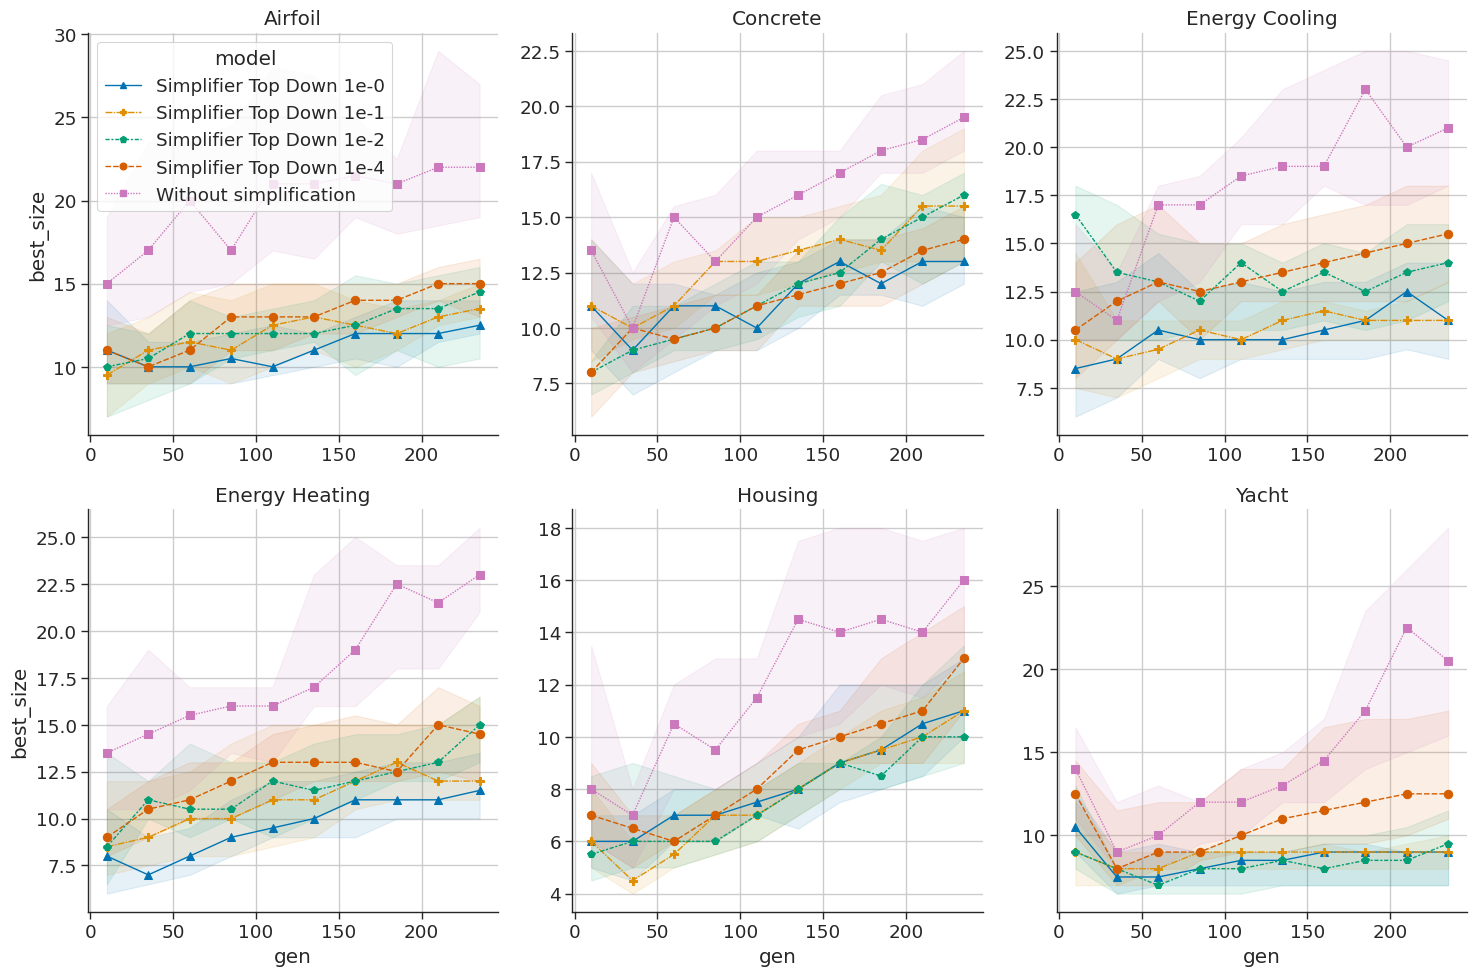

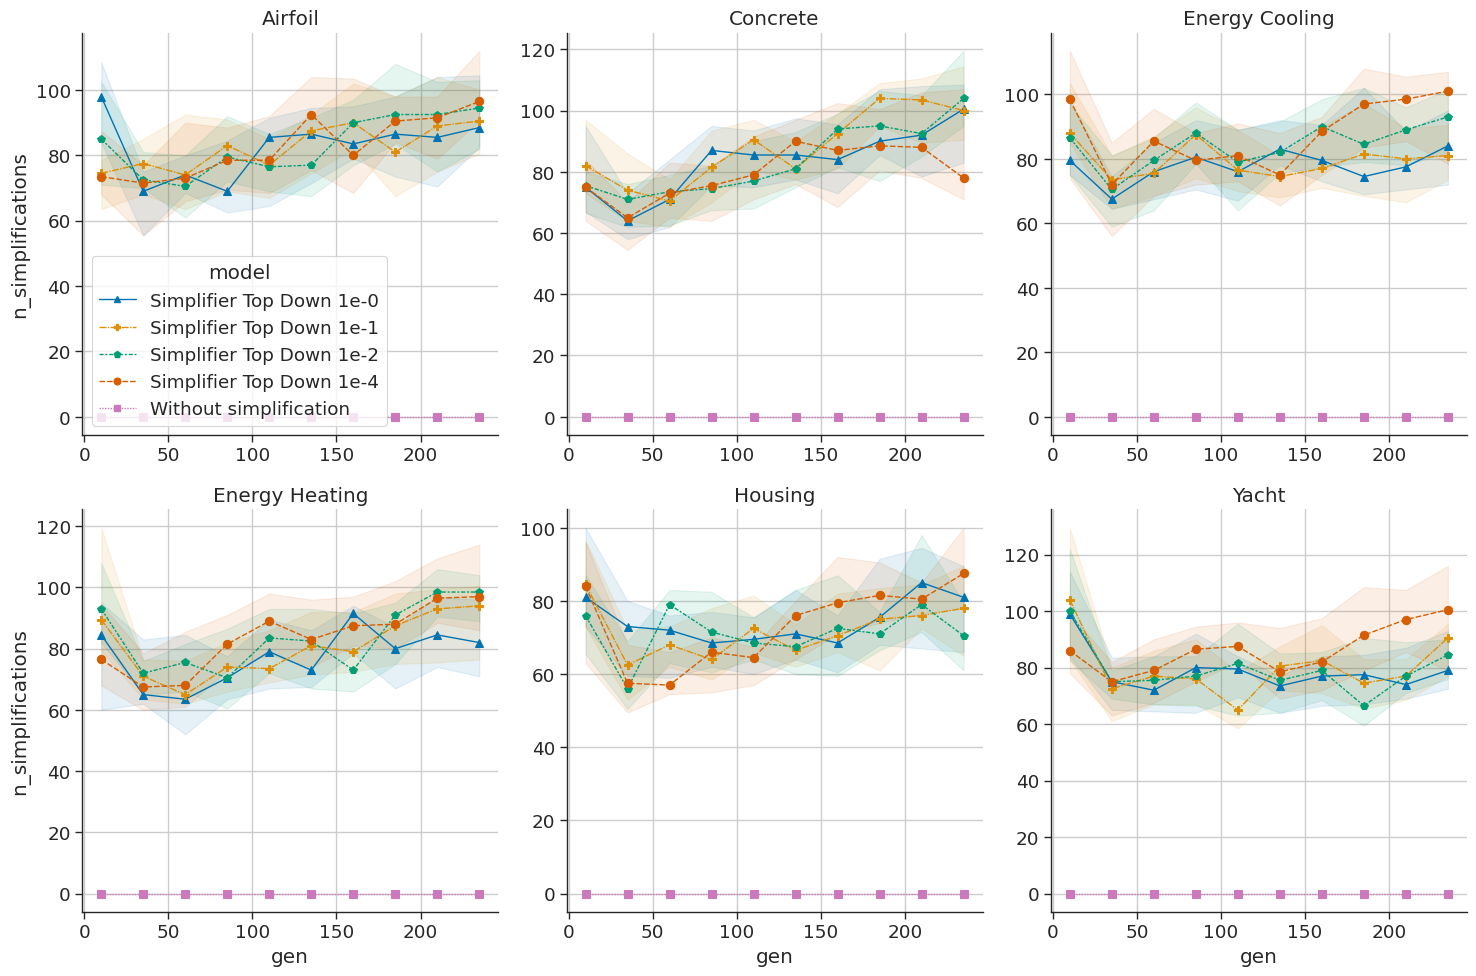

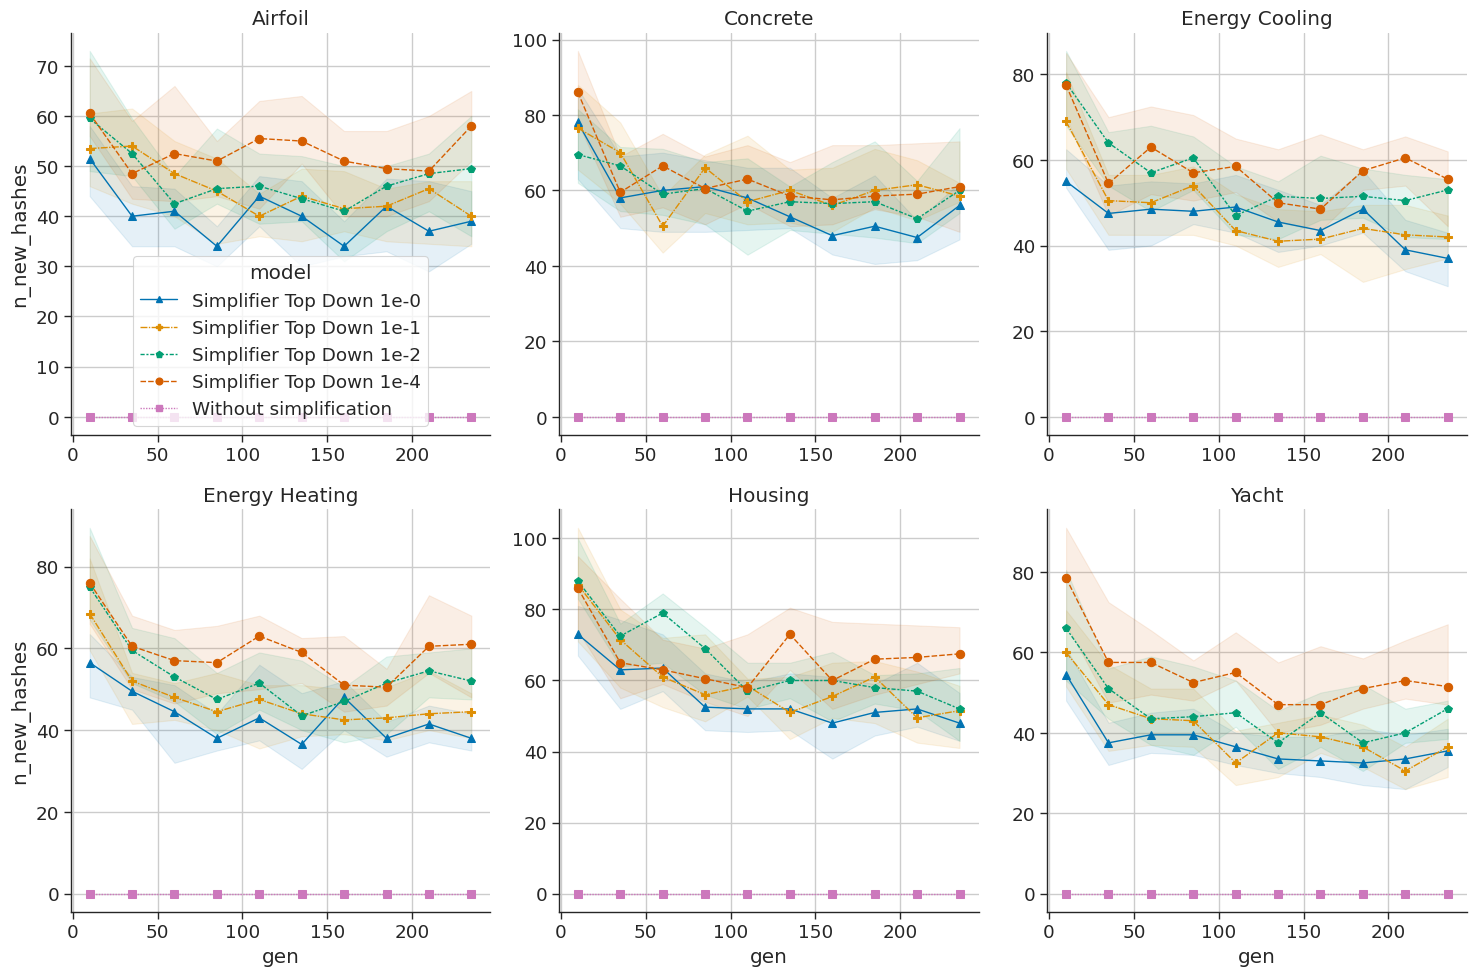

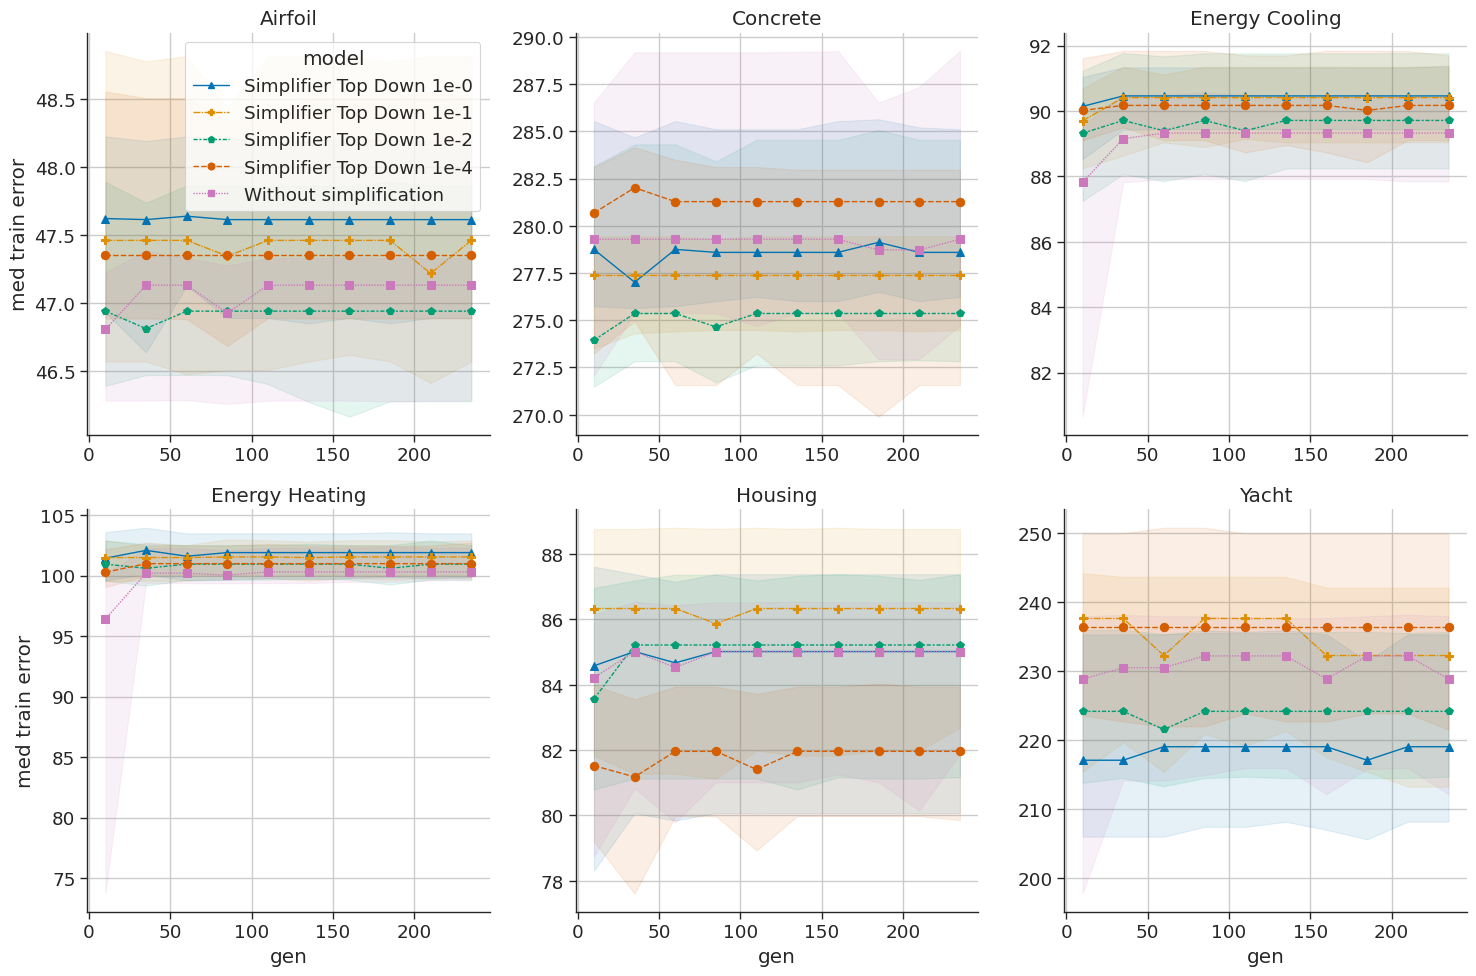

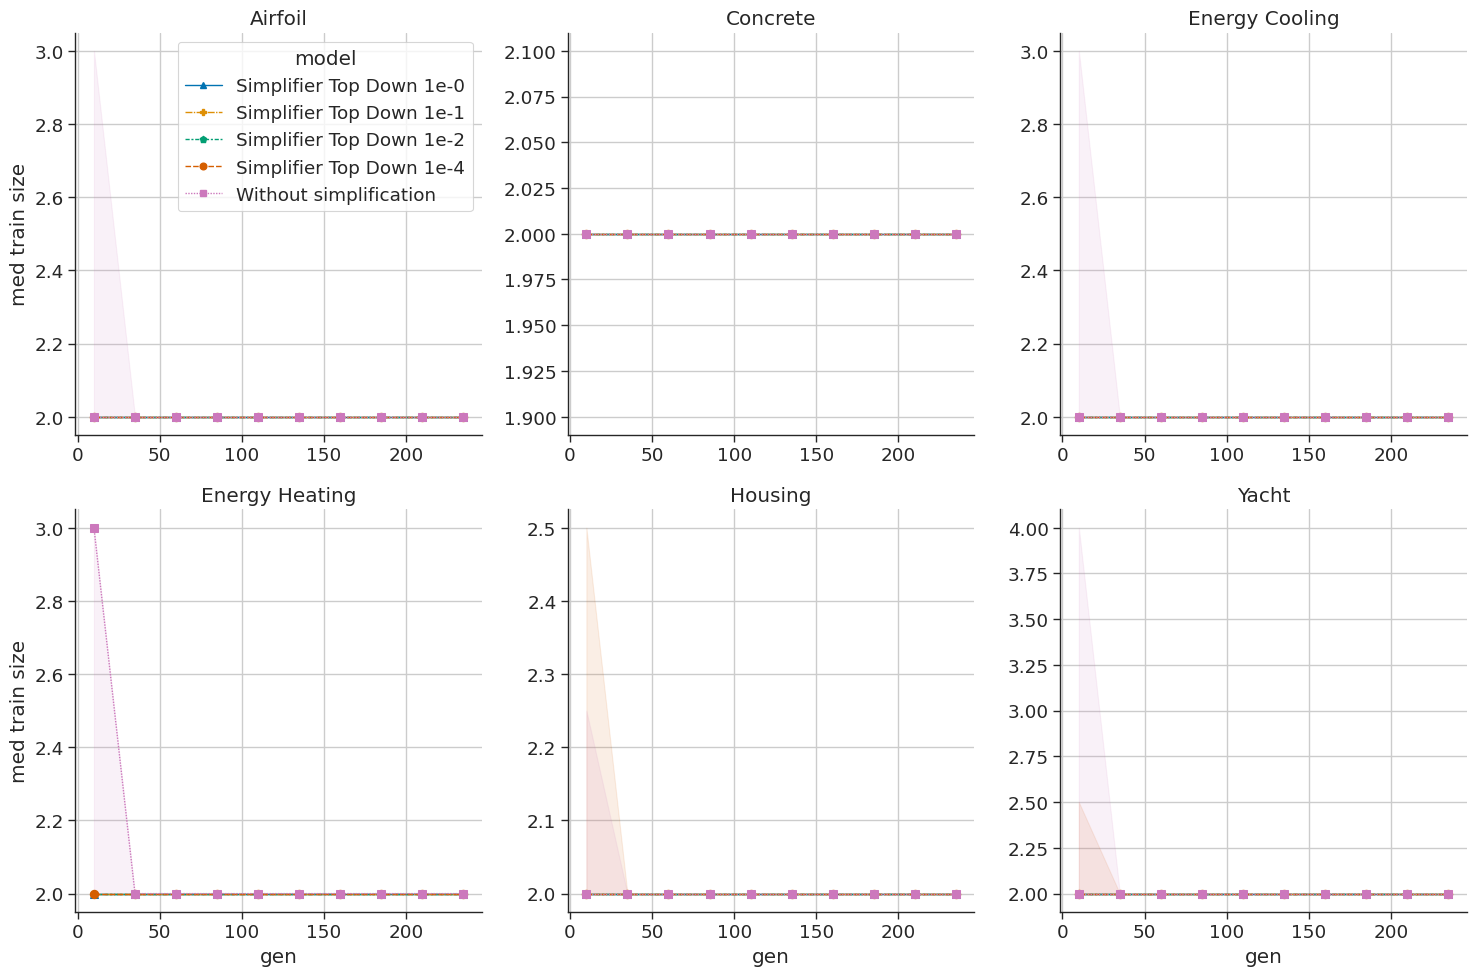

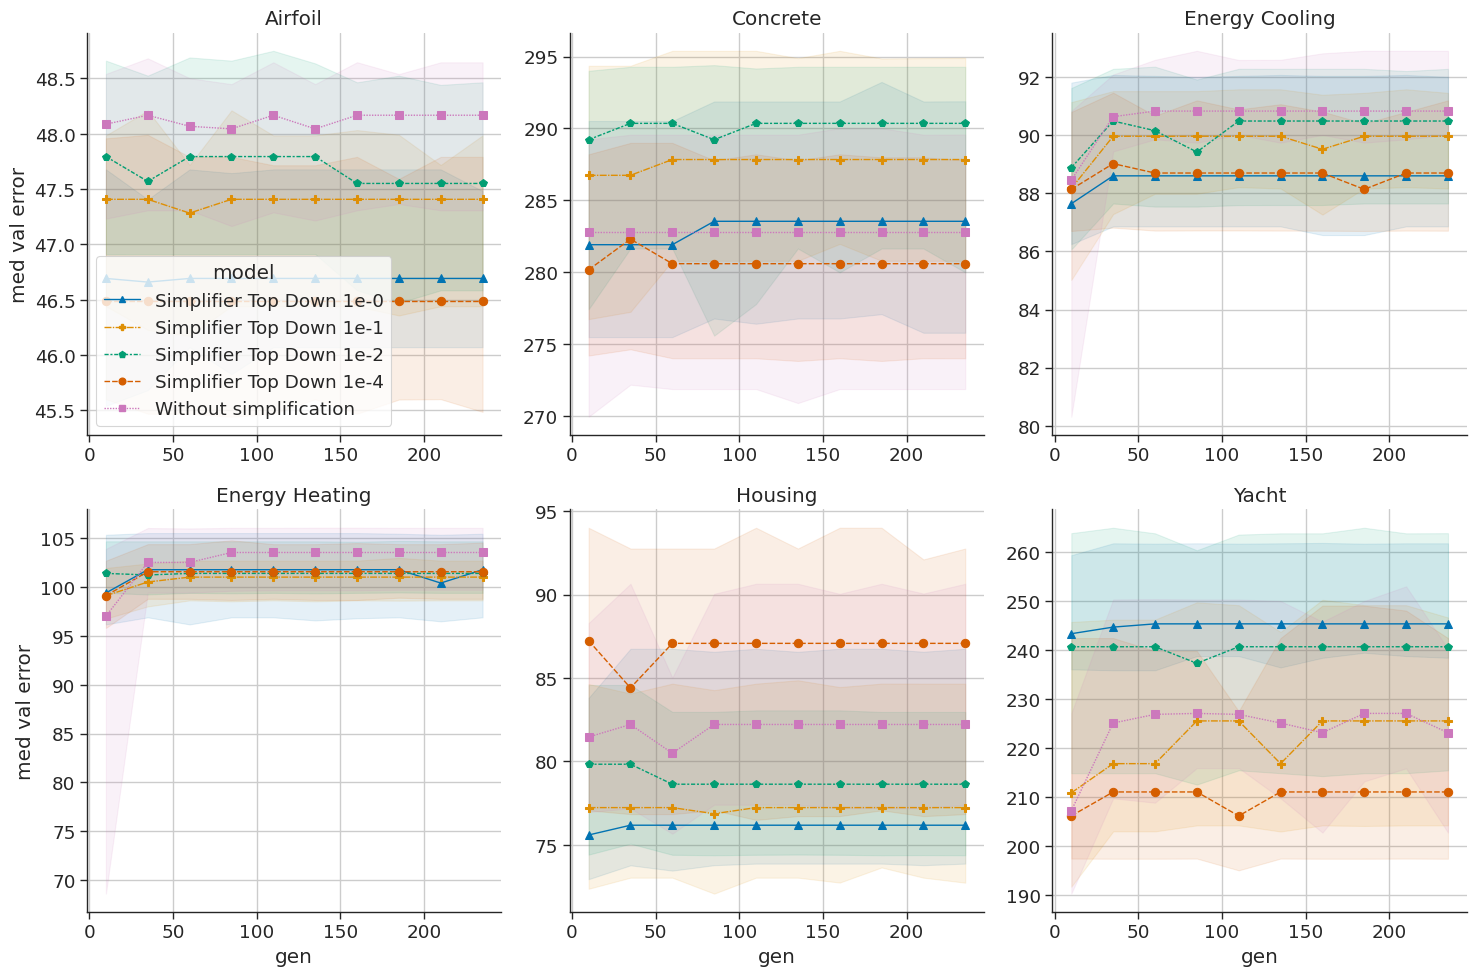

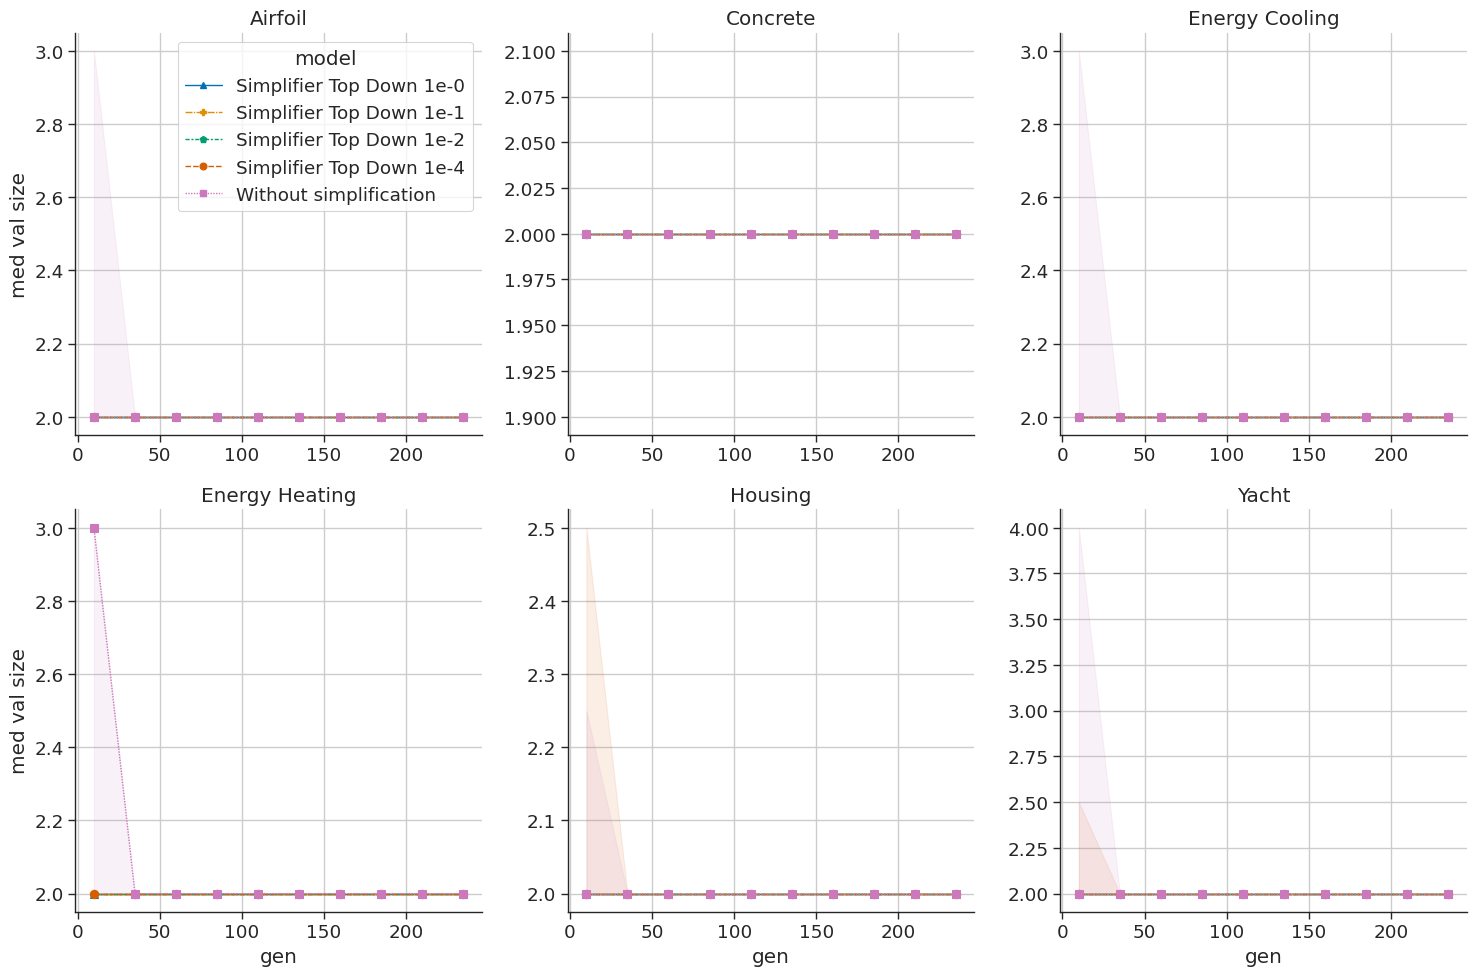

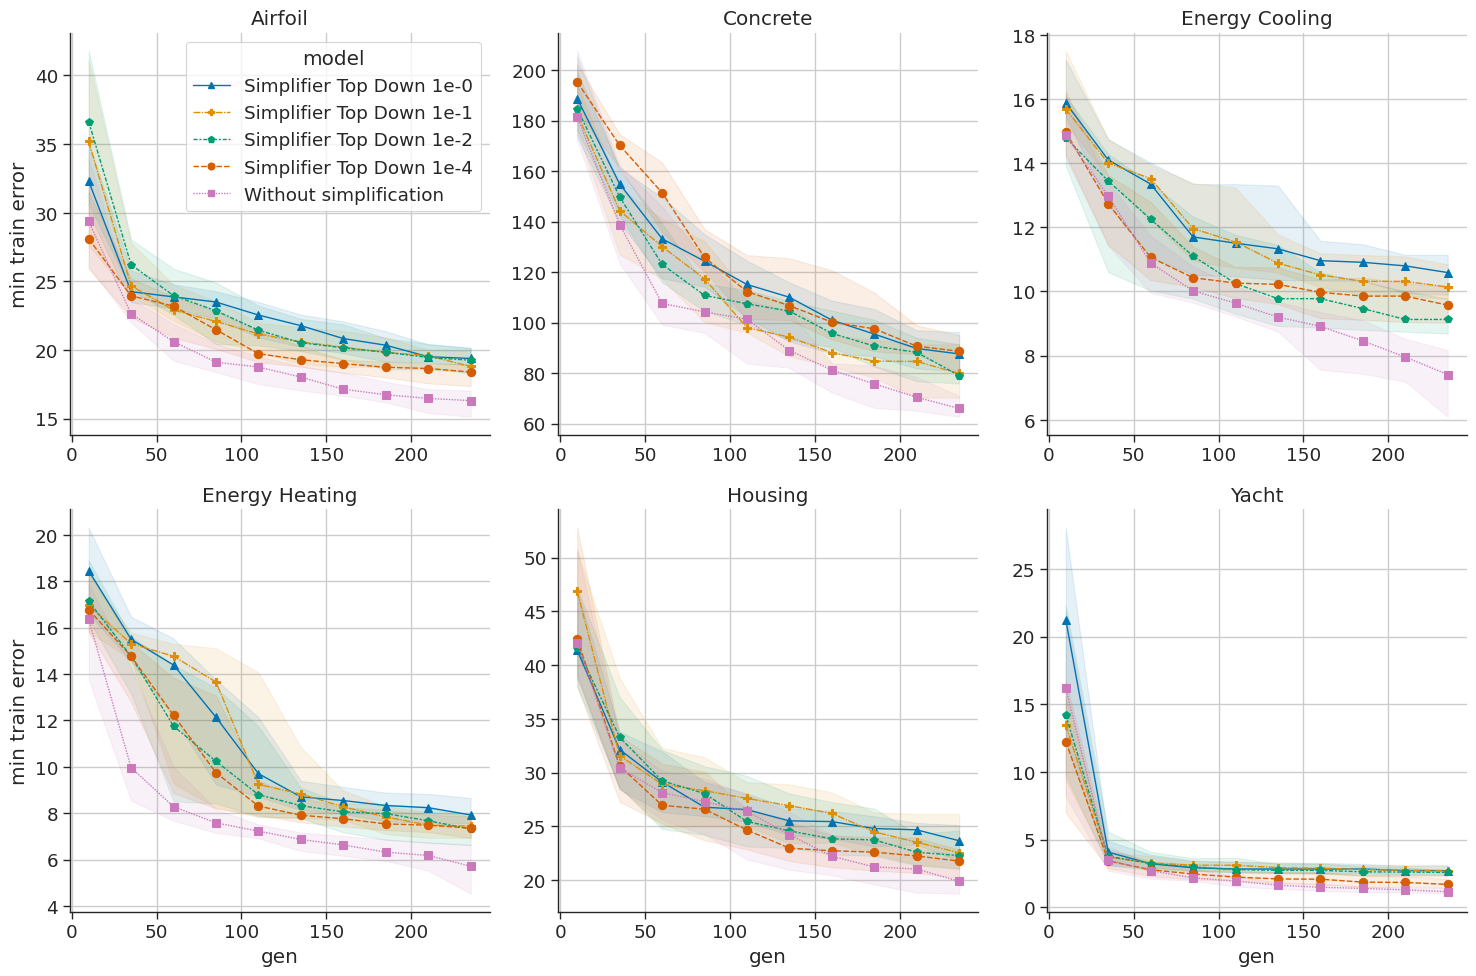

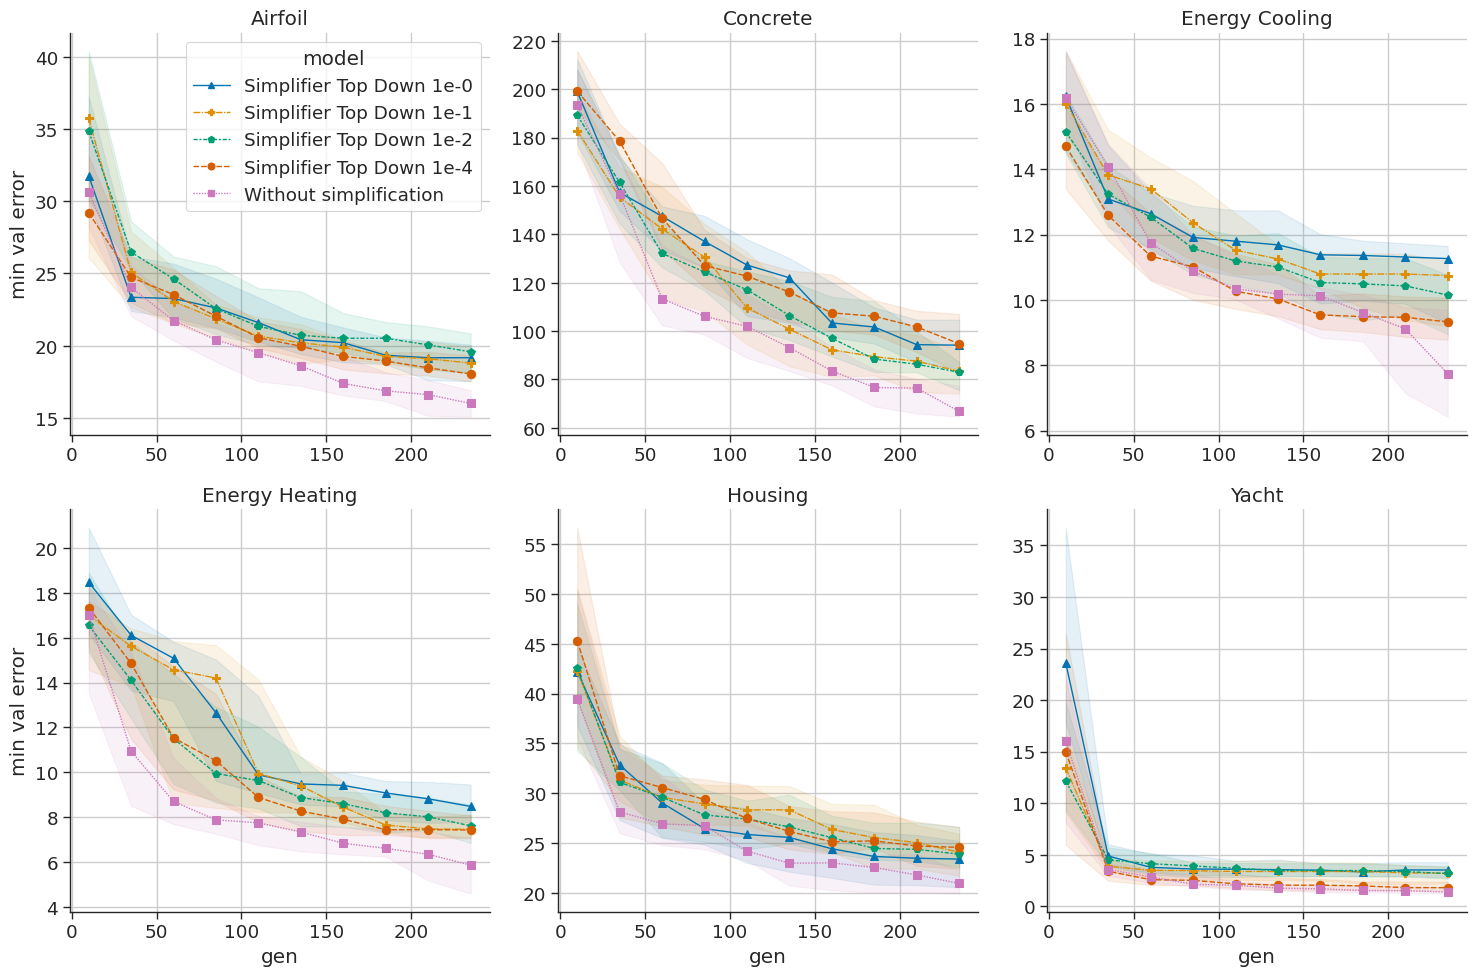

In [3]:
for col in [
    'best_size','n_simplifications','n_new_hashes','med train error','med train size',
    'med val error','med val size','min train error','min val error'
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, #errorbar=None, #('ci', 50),
        hue_order = order, estimator=np.median, markersize=6,
        
        # err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.75},
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)

    if False: # use log scale
        # g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()